In [24]:
import os
from glob import glob
import pandas as pd
import linecache

# カテゴリを配列で取得
categories = [name for name in os.listdir("text") if os.path.isdir("text/" + name)]
print(categories)
# ['movie-enter', 'it-life-hack', 'kaden-channel', 'topic-news', 'livedoor-homme', 'peachy', 'sports-watch', 'dokujo-tsushin', 'smax']

datasets = pd.DataFrame(columns=["content", "category"]) #content,categoryのカラムを作成
for cat in categories: #catにらカテゴリ—名を回す
    path = "text/" + cat + "/*.txt" #各カテゴリー配下へのpathを記載
    files = glob(path) #各カテゴリー配下の全てのファイルを取得
    for text_name in files: #上記で読み込んだすべてのファイルをtext_nameに回す
        '''
        カスタマイズ部分
        自分のコメント：クイッターではここをタイトルだけにしていたが、文章にした。計算はその分多くなるため処理に時間がかかると見込まれる
        '''
        with open(text_name, encoding='utf-8') as f:
            content = ''.join(f.readlines()[2:]) #分類に関係ありそうな3行目から文章を読み出す
            f.close()
        s = pd.Series([content, cat], index=datasets.columns) #titleには3行目の文章を、catにはカテゴリー名が入る
        datasets = datasets.append(s, ignore_index=True) #datasetsにsをappennd

# データフレームシャッフル
datasets = datasets.sample(frac=1).reset_index(drop=True)
datasets.head()

['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']


,content,category
0,NTTドコモ、学習支援サービス「ドコモゼミ」の1ヶ月分月額料金がキャッシュバックされるキャン...,smax
1,あなただけのオリジナルダンス作成！ Twitter/Facebook連動コンテンツ「重低音B...,it-life-hack
2,新しいヴァンパイアが誕生！ ジョニデ主演『ダーク・シャドウ』の公開日が決定\n こんなヴァン...,movie-enter
3,おはこんこん、ふぉっくす紺子です！アキバで流れる動画が決まりました【紺子にゅうす】\nおはこ...,it-life-hack
4,『ジョン・カーター』ディズニー生誕110周年記念コラボ特典付き前売鑑賞券を限定発売\n 『ス...,movie-enter


In [2]:
import MeCab
import re
import torch

tagger = MeCab.Tagger("-Owakati")

def make_wakati(sentence): #sentenceには文章が入る
    # MeCabで分かち書き
    sentence = tagger.parse(sentence)
    # 半角全角英数字除去
    sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
    # 記号もろもろ除去
    sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
    # スペースで区切って形態素の配列へ
    wakati = sentence.split(" ")
    # 空の要素は削除
    #wakati = list(filter(("").__ne__, wakati))
    wakati = filter(("").__ne__, wakati)
    return wakati

# テスト
test = "【人工知能】は「人間」の仕事を奪った"
print(make_wakati(test))
# ['人工', '知能', 'は', '人間', 'の', '仕事', 'を', '奪っ', 'た']

'''
文章の長さをそろえるためにパディングする。pythonはfor文の実行が遅いためできるだけ行列計算で処理したい
必要ありませんが勉強に
'''
# 単語ID辞書を作成する
word2index = {}
# 系列を揃えるためのパディング文字列<pad>を追加
# パディング文字列のIDは0とする
word2index.update({"<pad>":0})
for content in datasets["content"]: #ここの文章がリスト形式で読み込まれてるからエラーが起きてるっぽい。修正済み
    wakati = make_wakati(content)
    for word in wakati:
        if word in word2index: continue
        word2index[word] = len(word2index)
print("vocab size : ", len(word2index))
# vocab size :  56362 ゼロパディングした分が1つ増えた

'''
辞書が作成されたがかなり多い。必要ありませんが勉強に
'''

# 文章を単語IDの系列データに変換
# PyTorchのLSTMのインプットになるデータなので、もちろんtensor型で
def sentence2index(sentence):
    wakati = make_wakati(sentence)
    return torch.tensor([word2index[w] for w in wakati], dtype=torch.long) #どうやらtorchの形にしたいらしい
    #return [word2index[w] for w in wakati] #torchの形にしたくない場合は左をコメントアウト
    
# テスト
test = "例のあのメニューも！ニコニコ超会議のフードコートメニュー14種類紹介（前半）"
print(sentence2index(test))
# tensor([5607,    5,  900,  682,   45, 3886, 3536, 4711,    5, 3078, 9278,  682, 1192, 1705, 1018])

'''
テストでは文章が単語ベクトル化された.
ただし今回は学習済みモデル使用および自作モデルの関係上数値化はしないが勉強のため
'''

vocab size :  56362
tensor([ 3188,    18,  2641,  2959,     7,  9701,   528,  4607,    18,  6219,
        16622,  2959,  1900,   999,  2296])


'\nテストでは文章が単語ベクトル化された\n'

In [3]:
'''
数字化したけど学習済みのword2vec使うから使わない。勉強のため記載してます。
データセットの用意はこれ以降を見てください
'''
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle
import numpy as np

#labelの作成。現在データセットにはカテゴリ名しか入っていないためそれを数字に変換してやる必要がある。
cat2index = {}
for cat in categories:
    if cat in cat2index: continue
    cat2index[cat] = len(cat2index)
#出力は以下になる
#{'dokujo-tsushin': 0, 'it-life-hack': 1, 'kaden-channel': 2, 'livedoor-homme': 3, 'movie-enter': 4, 'peachy': 5, 'smax': 6, 'sports-watch': 7, 'topic-news': 8}

#分かち書きするための関数
def sentence2index(sentence):
    wakati = make_wakati(sentence)
    return [word2index[w] for w in wakati] #tensor型にしていない.前に定義したword2indexは辞書となります。

#カテゴリーを返すための関数
def category2index(cat):
    return [cat2index[cat]]

index_datasets_content_tmp = []
index_datasets_category = []

# 系列の長さの最大値を取得。この長さに他の系列の長さをあわせる
max_len = 0
for content, category in zip(datasets["content"], datasets["category"]):
    index_content = sentence2index(content) #1行ずつ分かち書きされ数字化される
    index_category = category2index(category) #1行ずつカテゴリーが数字に代わる
    index_datasets_content_tmp.append(index_content) #index_datasets_content_tmpに分かちガキから数字変換された文章がappendされていく
    index_datasets_category.append(index_category) #index_datasets_categoryにカテゴリーをappend
    if max_len < len(index_content):
        max_len = len(index_content)

# 系列の長さを揃えるために短い系列にパディングを追加
# 後ろパディングだと正しく学習できなかったので、前パディング
index_datasets_content = []
for content in index_datasets_content_tmp:
    for i in range(max_len - len(content)):#iは使わないの？？
        content.insert(0, 0) # 前パディング
#       content.append(0)　# 後ろパディング
    index_datasets_content.append(content)
    
#print(index_datasets_content[0])#あれ？数字化されてない？　修正済み
#print(index_datasets_category[0])#こっちは数字化されている
print(np.shape(index_datasets_content))
print(np.shape(index_datasets_category))

'''
数字化したけど学習済みのword2vec使うから使わない。勉強のため記載してます。
データセットの用意はこれ以降を見てください
'''

(7376, 5067)
(7376, 1)


'\n数字化したけど学習済みのword2vec使うから使わないかも.参考にって感じで\n'

In [4]:
'''
embedderの用意
今回はembedderはfasttextの学習済みモデルを参考にする
url:https://qiita.com/Hironsan/items/513b9f93752ecee9e670
'''

#embed層を含めて学習させると時間がかかってしまう
#あらかじめ作成しロードするようにしたい
import os
from gensim.models import keyedvectors
if os.path.exists("model.vec"):
    #model = word2vec.Word2VecKeyedVectors.load_word2vec_format("embedder.model")
    model = keyedvectors.KeyedVectors.load_word2vec_format("model.vec")
else:
    print("今回学習済みmodelを使用するため、モデルをローカルにダウンロードしてきてください")

In [5]:
'''
単語が該当しなかった場合の処理も記載しておく
'''
def embed_one_word_via_model(word, model):
    try:
        return model[word]
    except:
        return np.zeros(model.vector_size) #学習済みモデルに単語がなかった場合０で埋めるようにしている。

In [6]:
'''
説明変数の用意
文章数を統一させた
'''
wakati = []
for i in range(2000): #7376が記事数だが出力を抑えたいので2000記事にする
    data = make_wakati(datasets["content"][i]) 
    list = []
    for d in data:
        list.append(d)
    if len(list) >=300:
        list = list[:300]
    else:
        list.extend([" " for i in range(300 - len(list))])    
    wakati.append(list)

#d = wakati[0]
#print(d)
#print(wakati[3])

embedding = []
for i in wakati:
    data = i
    x = []
    for word in data:
        x.append(embed_one_word_via_model(word,model))
    embedding.append(np.array(x))

#embedding.append(np.array([embed_one_word_via_model(word,model) for word in wakati]))
    
embedding = np.array(embedding)

print(np.shape(embedding))#出力が3次元となっていない(バッチ数,時刻（単語数）,次元)となっていないとデータとして扱えない

(2000, 300, 300)


In [7]:
'''
ラベルデータ（目的値）の作成
'''
cat2index = {}
for cat in categories:
    if cat in cat2index: continue
    cat2index[cat] = len(cat2index)
print(cat2index)
    
def category2index(cat):
    return cat2index[cat]
    #return cat2index[cat]


labels=[]
for label in datasets["category"][:2000]:
    label = category2index(label)
    labels.append(label)

labels = np.array(labels)

print(np.shape(labels))

{'dokujo-tsushin': 0, 'it-life-hack': 1, 'kaden-channel': 2, 'livedoor-homme': 3, 'movie-enter': 4, 'peachy': 5, 'smax': 6, 'sports-watch': 7, 'topic-news': 8}
(2000,)


In [8]:
'''
多値分類にする関係上
ラベルをワンホットベクトルに変換する
'''
print(labels)
n_labels = len(np.unique(labels)) #分類クラスの数＝９
newlabels = np.eye(n_labels)[labels]
print(newlabels)
print(np.shape(newlabels))

'''
各サンプルの出力の値が1つじゃなく9個になっていることに注意
'''

[1 2 8 ... 1 5 1]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(2000, 9)


'\n各サンプルの出力の値が1つじゃなく9個になっていることに注意\n'

In [9]:
X_train, X_test, T_train, T_test = train_test_split(embedding, newlabels, random_state=0)
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(T_train))
print(np.shape(T_test))

(1500, 300, 300)
(500, 300, 300)
(1500, 9)
(500, 9)


In [ ]:
'''
以下モデル
'''

In [10]:
class Affine:
    def __init__(self, W, b):
        self.params,self.grads,self.x = [W, b],[np.zeros_like(W), np.zeros_like(b)],None

    def forward(self, x):
        N, D = x.shape
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        x = self.x
        N, D = x.shape
        W, b = self.params
        db = np.sum(dout, axis=0)
        dW = np.dot(x.T, dout)
        dx = np.dot(dout, W.T)
        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

In [11]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]
            
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr,self.iter = lr,0
        self.beta1,self.beta2 = beta1,beta2
        self.m,self.v = None,None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)
        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))
    return x

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

In [13]:
class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss,self.y,self.t = None,None,None
        
    def forward(self, x, t):
        self.t = t
        x = x.flatten()
        self.y = sigmoid(x)
        self.loss = -np.mean(np.log(self.y + 1e-7) * t + np.log(1 - self.y + 1e-7) * (1 - t))
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t)/batch_size
        dx = dx.reshape(-1,1)
        return dx

In [14]:
'''
今回多値分類なのでソフトマックス用のlossを作らないといけないかも
'''
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    # 全体的に修正
    def forward(self, xs, ts):
        N, C = xs.shape #C:クラスサイズ
        ts = ts.argmax(axis=1)
        ys = softmax(xs)
        ls = np.log(ys[np.arange(N), ts])
        loss = -np.sum(ls)
        loss /= len(ts)
        self.cache = (ts, ys, (N, C))
        return loss

    # 全体的に修正
    def backward(self, dout=1):
        ts, ys, (N, C) = self.cache
        dx = ys
        dx[np.arange(N), ts] -= 1
        dx *= dout
        dx /= len(ys)
        dx = dx.reshape((N, C))
        return dx

In [15]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params 
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b 
        h_next = np.tanh(t) 
        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        dt = dh_next * (1 - h_next ** 2) 
        db = np.sum(dt, axis=0) 
        dWh = np.dot(h_prev.T, dt) 
        dh_prev = np.dot(dt, Wh.T) 
        dWx = np.dot(x.T, dt) 
        dx = np.dot(dt, Wx.T) 
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        return dx, dh_prev

In [16]:
class TimeRNN:
    def __init__(self,input_size, output_size, stateful=False):
        D, H = input_size, output_size
        rn = np.random.randn
        np.random.seed(0)
        Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        b = np.zeros(H).astype('f')
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful
        self.input_shapes = None

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        self.input_shapes = [N,T,D]
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h) 
            hs[:, t, :] = self.h
            self.layers.append(layer)
        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, D = self.input_shapes
        D, H = Wx.shape      
        if dhs.ndim == 2:
            temp = np.zeros((N,T,H))
            temp[:,-1,:] = dhs
            dhs = temp
        N, T, H = dhs.shape
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h):
        self.h = h
    def reset_state(self):
        self.h = None

In [17]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b 
        f,g,i,o = A[:, :H],A[:, H:2*H],A[:, 2*H:3*H],A[:, 3*H:]
        f,g,i,o = sigmoid(f),np.tanh(g),sigmoid(i),sigmoid(o) 
        c_next = f * c_prev + g * i 
        h_next = o * np.tanh(c_next) 
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        tanh_c_next = np.tanh(c_next)
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2) 
        dc_prev = ds * f 
        di,df,do,dg = ds * g, ds * c_prev, dh_next * tanh_c_next, ds * i
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)
        dA = np.hstack((df, dg, di, do))
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)
        return dx, dh_prev, dc_prev

In [18]:
class TimeLSTM:
    def __init__(self, input_size, output_size, stateful=False):
        D,H = input_size, output_size
        rn = np.random.randn
        np.random.seed(0)        
        Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f') 
        Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f') 
        b = np.zeros(4 * H).astype('f') 
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        self.input_shapes = None

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        self.input_shapes = [N,T,D]
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c) 
            hs[:, t, :] = self.h
            self.layers.append(layer)
        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        H = Wh.shape[0]
        N, T, D = self.input_shapes
        if dhs.ndim == 2:
            temp = np.zeros((N,T,H))
            temp[:,-1,:] = dhs
            dhs = temp
        N, T, H = dhs.shape
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc) 
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c
    def reset_state(self):
        self.h, self.c = None, None

In [19]:
class SimpleRNNClassifier:
    # 修正
    # def __init__(self, wordvec_size, hidden_size):
    def __init__(self, wordvec_size, hidden_size, class_size):
        # 修正
        # D, H = wordvec_size, hidden_size
        D, H, C = wordvec_size, hidden_size, class_size
        rn = np.random.randn
        np.random.seed(0)
        # 重みの初期化
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        # 修正
        # affine_W = (rn(H, 1) / np.sqrt(H)).astype('f')
        # affine_b = np.zeros(1).astype('f')
        affine_W = (rn(H, C) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(C).astype('f')
        # レイヤの生成
        self.affine_layer = Affine(affine_W, affine_b)
        # 修正
        # self.loss_layer = SigmoidWithLoss()
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = TimeRNN(D, H, stateful=False)
        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        self.params += self.rnn_layer.params
        self.grads += self.rnn_layer.grads
        self.params += self.affine_layer.params
        self.grads += self.affine_layer.grads

    def forward(self, xs, ts):
        xs = self.predict(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def predict(self, xs):
        #xs = self.rnn_layer.forward(xs)[######問1-1######]
        xs = self.rnn_layer.forward(xs)[:, -1, :] #形式はN, T, D = xs.shape（timelstmクラスを参照
        xs = self.affine_layer.forward(xs)
        return xs

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        dout = self.affine_layer.backward(dout)
        dout = self.rnn_layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

In [20]:
class LSTMClassifier:
    # 修正
    # def __init__(self, wordvec_size, hidden_size):
    def __init__(self, wordvec_size, hidden_size, class_size):
        D, H, C = wordvec_size, hidden_size, class_size
        rn = np.random.randn
        np.random.seed(0)

        # 重みの初期化
        rnn_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H, C) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(C).astype('f')

        # レイヤの生成
        self.affine_layer = Affine(affine_W, affine_b)
        # 修正
        # self.loss_layer = SigmoidWithLoss()
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = TimeLSTM(D, H, stateful=False)

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        self.params += self.rnn_layer.params
        self.grads += self.rnn_layer.grads
        self.params += self.affine_layer.params
        self.grads += self.affine_layer.grads

    def forward(self, xs, ts):
        xs = self.predict(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def predict(self, xs):
        #xs = self.rnn_layer.forward(xs)[######問1-2######] 
        xs = self.rnn_layer.forward(xs)[:, -1, :]
        xs = self.affine_layer.forward(xs)
        return xs

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        dout = self.affine_layer.backward(dout)
        dout = self.rnn_layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

In [21]:
lr = 0.01
n_epoch = 50
eval_interval = 1

In [22]:
# 修正
# rnn_model = SimpleRNNClassifier(25, 15)
# lstm_model = LSTMClassifier(25, 15)
rnn_model = SimpleRNNClassifier(300, 100, len(categories))
lstm_model = LSTMClassifier(300, 100, len(categories))
optimizer1 = Adam(lr)
optimizer2 = Adam(lr)
batch_size = 500
rnn_loss_list = []
lstm_loss_list = []

np.random.seed(0)
for epoch in range(n_epoch):
    total_rnn_loss = 0
    total_lstm_loss = 0
    perm = np.random.permutation(len(X_train))
    for i, idx in enumerate(range(0, len(X_train), batch_size)):
        X_batch = X_train[perm[idx:idx+batch_size]]
        T_batch = T_train[perm[idx:idx+batch_size]]
        
        rnn_loss = rnn_model.forward(X_batch, T_batch)
        rnn_model.backward()
        optimizer1.update(rnn_model.params, rnn_model.grads)
        total_rnn_loss += rnn_loss*len(X_batch)
        
        lstm_loss = lstm_model.forward(X_batch, T_batch)
        lstm_model.backward()
        optimizer2.update(lstm_model.params, lstm_model.grads)
        total_lstm_loss += lstm_loss*len(X_batch)
        if i % eval_interval == 0:
            print('| idx %d / %d | RNN loss %.2f | LSTM loss %.2f |'
                 %(idx, len(X_train), total_rnn_loss/(idx+batch_size), total_lstm_loss/(idx+batch_size)))
    average_rnn_loss = total_rnn_loss / len(X_train)
    rnn_loss_list.append(average_rnn_loss)
    average_lstm_loss = total_lstm_loss / len(X_train)
    lstm_loss_list.append(average_lstm_loss)
    
    rnn_pred = rnn_model.predict(X_test).flatten()
    lstm_pred = lstm_model.predict(X_test).flatten()
    # 修正
    # rnn_pred = rnn_model.predict(X_test).flatten()
    # lstm_pred = lstm_model.predict(X_test).flatten()
    # rnn_accuracy = ((rnn_pred > 0) == T_test).mean() * 100
    # lstm_accuracy = ((lstm_pred > 0) == T_test).mean() * 100
    rnn_pred = rnn_model.predict(X_test).argmax(axis=1)
    lstm_pred = lstm_model.predict(X_test).argmax(axis=1)
    rnn_accuracy = (rnn_pred == T_test.argmax(axis=1)).mean() * 100
    lstm_accuracy = (lstm_pred == T_test.argmax(axis=1)).mean() * 100
    print('| epoch %d | RNN loss %.2f | LSTM loss %.2f | RNN accuracy %.2f | LSTM accuracy %.2f'
          % (epoch+1, average_rnn_loss, average_lstm_loss, rnn_accuracy, lstm_accuracy))

| idx 0 / 1500 | RNN loss 2.26 | LSTM loss 2.20 |
| idx 500 / 1500 | RNN loss 2.25 | LSTM loss 2.18 |
| idx 1000 / 1500 | RNN loss 2.24 | LSTM loss 2.15 |
| epoch 1 | RNN loss 2.24 | LSTM loss 2.15 | RNN accuracy 14.40 | LSTM accuracy 27.00
| idx 0 / 1500 | RNN loss 2.08 | LSTM loss 1.88 |
| idx 500 / 1500 | RNN loss 2.08 | LSTM loss 2.01 |
| idx 1000 / 1500 | RNN loss 2.09 | LSTM loss 1.95 |
| epoch 2 | RNN loss 2.09 | LSTM loss 1.95 | RNN accuracy 11.40 | LSTM accuracy 30.00
| idx 0 / 1500 | RNN loss 2.09 | LSTM loss 1.74 |
| idx 500 / 1500 | RNN loss 2.09 | LSTM loss 1.92 |
| idx 1000 / 1500 | RNN loss 2.09 | LSTM loss 2.21 |
| epoch 3 | RNN loss 2.09 | LSTM loss 2.21 | RNN accuracy 18.20 | LSTM accuracy 16.00
| idx 0 / 1500 | RNN loss 2.03 | LSTM loss 2.42 |
| idx 500 / 1500 | RNN loss 2.13 | LSTM loss 2.29 |
| idx 1000 / 1500 | RNN loss 2.13 | LSTM loss 2.23 |
| epoch 4 | RNN loss 2.13 | LSTM loss 2.23 | RNN accuracy 15.40 | LSTM accuracy 17.60
| idx 0 / 1500 | RNN loss 2.09 | LST

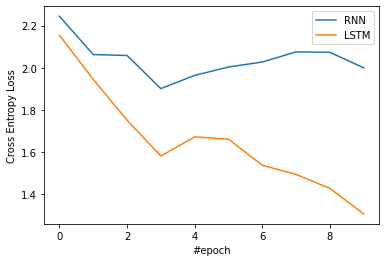

In [23]:
"""
1回目考察
lr = 0.01
n_epoch = 10
eval_interval = 1
隠れ層の数=100
batchsize=300

LSTMは順調にlossが順調に減っている
RNNは少し学習に苦しんでいそう→学習がうまくいってなさそうなので、バッチ数を増やしてみることにする

両モデルもう少しエポック数をふやしてその先の結果をみてみたいところ
"""
import matplotlib.pyplot as plt
plt.plot(range(n_epoch), rnn_loss_list)
plt.plot(range(n_epoch), lstm_loss_list)
plt.legend(["RNN", "LSTM"])
plt.xlabel("#epoch")
plt.ylabel("Cross Entropy Loss")
plt.show()

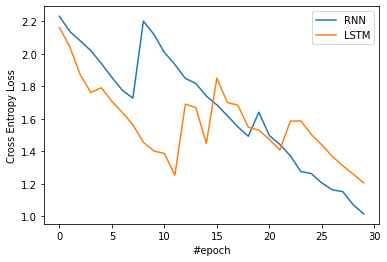

In [32]:
"""
2回目考察
lr = 0.01
n_epoch = 30
eval_interval = 1
隠れ層の数=100
batchsize=500

RNNは最初のほうが安定しないがlossは着実に減るようになった。→バッチ数はこのままでいってみる
LSTMはepoch数が10を超えるといったんlossが上昇する。→もう少しエポック数を増やして挙動を確かめたい

RNNmaxaccuracy:27.20
LSTMmaxaccuracy:48.40
学習率も上昇傾向にある→このままエポック数をふやしてみることにする
"""
import matplotlib.pyplot as plt
plt.plot(range(n_epoch), rnn_loss_list)
plt.plot(range(n_epoch), lstm_loss_list)
plt.legend(["RNN", "LSTM"])
plt.xlabel("#epoch")
plt.ylabel("Cross Entropy Loss")
plt.show()

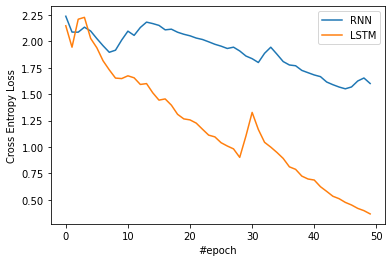

In [23]:
"""
3回目考察
lr = 0.01
n_epoch = 50
eval_interval = 1
隠れ層の数=100
batchsize=500

RNNはデータシャッフルを一回挟んだので精度が悪くなったように見える
LSTMはaccuracy,lossともに順調であると思われる

RNNmaxaccuracy:28.40
LSTMmaxaccuracy:63.60
学習率も上昇傾向にある

RNNはやはり精度が悪く見える。lossはエポック数を増やせば減りそうだが、学習が遅いように見える
LSTMに関してはこの後のlossも多少は減りそう。精度がいいとは言えないが、ほぼ予測はできているのではないか。
"""
import matplotlib.pyplot as plt
plt.plot(range(n_epoch), rnn_loss_list)
plt.plot(range(n_epoch), lstm_loss_list)
plt.legend(["RNN", "LSTM"])
plt.xlabel("#epoch")
plt.ylabel("Cross Entropy Loss")
plt.show()